Here we create the database from files and prepare it for neural net

<h1> General Settings </h>

In [1]:
# Imports
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import utils

In [2]:
# Settings

all_names = [
    'ADGU101504',
    'ALUR012904',
    'BECA011405',
    'BRCA062405',
    'BRLO041102',
    'BTOL083105',
    'BTOL090105',
    'CAPO092605',
    'CRCA020205',
    'ESCI031905',
    'TAGO061203']

path_rec = "ssdata/register/"
rec_postamble = ".rec"

path_marks = "ssdata/label/marks/"
marks_preamble = "FixedSS_"
marks_postamble = ".txt"

path_states = "ssdata/label/states/"
states_preamble = "StagesOnly_"
states_postamble = ".txt"

params = {
    'channel': 1,           # Channel to be used
    'dur_epoch': 30,        # Time of window page [s]
    'n2_val': 3,            # N2 state coding value
    'context': 5            # Context to be added before and after an epoch, in [s]
    # 'dur_min_ss': 0.3,      # Min SS duration [s]
    # 'dur_max_ss': 3.0       # Max SS duration [s]
}

<h1> Read Files </h>

In [3]:
# Read everything
signal_list = []
marks_list = []
states_list = []
for i in range(len(all_names)):
    # Read EEG Signal
    path_edf_file = path_rec + all_names[i] + rec_postamble
    signal, fs = utils.dataload.read_eeg(path_edf_file, params['channel'])
    signal_list.append(signal)
    # Read Expert marks
    path_marks_file = path_marks + marks_preamble + all_names[i] + marks_postamble
    marks = utils.dataload.read_marks(path_marks_file, params['channel'])
    marks_list.append(marks)
    # Read states
    path_states_file = path_states + states_preamble + all_names[i] + states_postamble
    states = utils.dataload.read_states(path_states_file)
    states_list.append(states)    
params['fs'] = fs           # Save sampling frequency [Hz]

print(len(signal_list), ' EEG signals have been read.')
print(len(marks_list), ' sleep spindle marks files have been read.')
print(len(states_list), ' state annotations files have been read.')
print('Sampling Frequency: ', fs, 'Hz')

11  EEG signals have been read.
11  sleep spindle marks files have been read.
11  state annotations files have been read.
Sampling Frequency:  200 Hz


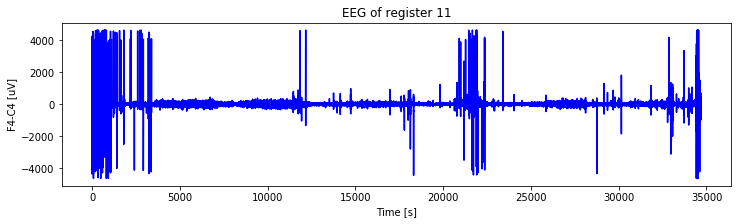

In [4]:
# Show complete EEG
ind = 10

# Show plot of signal
n_total = signal_list[ind].shape[0]
time_axis = np.arange(0, n_total, 1) / params['fs']
plt.figure(figsize=(12, 3))
plt.plot(time_axis, signal_list[ind], 'b')
plt.xlabel('Time [s]')
plt.ylabel('F4-C4 [uV]')
plt.title('EEG of register {0}'.format(ind+1))
plt.show()

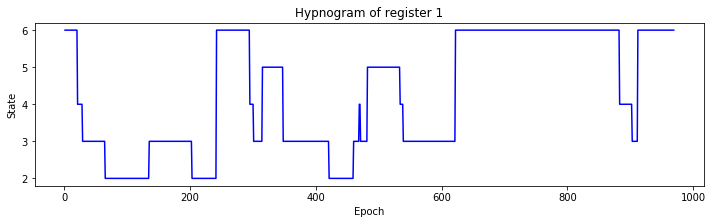

In [5]:
# Show states
ind = 0

n_total = states_list[ind].shape[0]
epoch_axis = np.arange(1, n_total+1, 1)
plt.figure(figsize=(12, 3))
plt.plot(epoch_axis, states_list[ind], 'b')
plt.xlabel('Epoch')
plt.ylabel('State')
plt.title('Hypnogram of register {0}'.format(ind+1))
plt.show()

(2672, 2)  Total marks


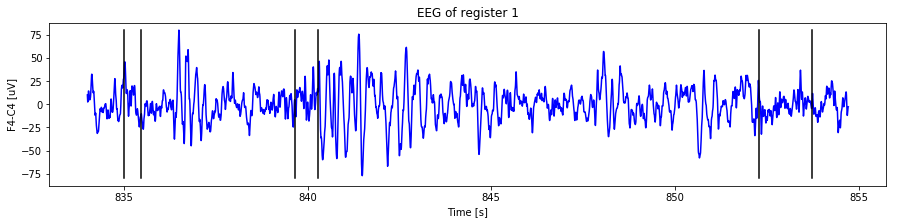

In [11]:
# Show marks

ind = 0
marks_ind = marks_list[ind]
print(marks_ind.shape, " Total marks")

# Let's show the first three marks
from_mark = 0
to_mark = 2
sample_start = marks_ind[from_mark, 0] - params['fs']
sample_end = marks_ind[to_mark, 1] + params['fs']
segment_eeg = signal_list[ind][sample_start:sample_end]
time_axis = np.arange(sample_start, sample_end, 1) / params['fs']
plt.figure(figsize=(15, 3))
plt.plot(time_axis, segment_eeg, 'b')
max_y = max(abs(segment_eeg))
for index in range(from_mark, to_mark+1):
    beg_x = [marks_ind[index, 0] / params['fs'], marks_ind[index, 0] / params['fs']]
    end_x = [marks_ind[index, 1] / params['fs'], marks_ind[index, 1] / params['fs']]
    plt.plot(beg_x, [-max_y, max_y], 'k')
    plt.plot(end_x, [-max_y, max_y], 'k')

plt.xlabel('Time [s]')
plt.ylabel('F4-C4 [uV]')
plt.title('EEG of register {0}'.format(ind+1))
plt.show()

<h1> Extract and Normalize N2 Epochs </h>

In [7]:
# Extraction of N2 epochs in data frame of Pandas
n2eeg_df = utils.transform.get_n2_epochs(signal_list, states_list, marks_list, params)

print(n2eeg_df.dtypes)    
n2eeg_df.head()


ID_REG         int64
ID_SEG         int64
ID_EPOCH       int64
EEG_DATA      object
MARKS_DATA    object
dtype: object


,ID_REG,ID_SEG,ID_EPOCH,EEG_DATA,MARKS_DATA
0,0,0,28,"[28.4101625085832, 30.94804303044175, 36.44678...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,0,29,"[-5.28725108720531, -4.300297550926985, -2.044...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,0,30,"[-14.874799725337606, -16.284733348592354, -15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,0,31,"[42.79148546578164, 49.700160219729916, 57.031...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,0,32,"[-12.195925841153581, -21.078507667658503, -28...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [8]:
# Clip normalization
n2eeg_df = utils.transform.clip_normalize(n2eeg_df, 99)

print(n2eeg_df.dtypes)    
n2eeg_df.head()


ID_REG         int64
ID_SEG         int64
ID_EPOCH       int64
EEG_DATA      object
MARKS_DATA    object
dtype: object


,ID_REG,ID_SEG,ID_EPOCH,EEG_DATA,MARKS_DATA
0,0,0,28,"[1.3352126143722207, 1.4559390677904294, 1.717...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,0,29,"[-0.26776640601399426, -0.22081722968469086, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,0,30,"[-0.723844118927227, -0.7909143708262318, -0.7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,0,31,"[2.0193291837420695, 2.3479734180471934, 2.696...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,0,32,"[-0.5964106403191178, -1.0189532272828483, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


[1.33521261 1.45593907 1.71751305 ... 0.37610801 0.38281504 0.38281504]


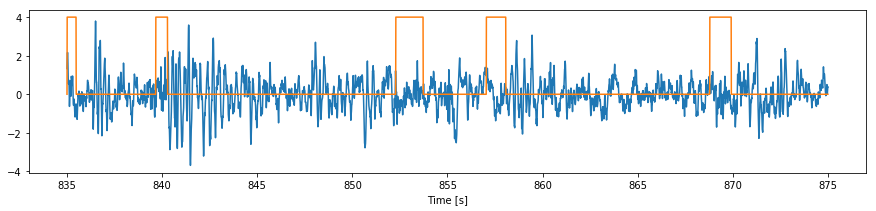

28


In [18]:
# Show a certain epoch to see the results

idx = 0
print(n2eeg_df.loc[idx, 'EEG_DATA'])
epoch = n2eeg_df.loc[idx, 'ID_EPOCH']
sample_start = (epoch * params['dur_epoch'] - params['context']) * params['fs']
sample_end = ((epoch + 1) * params['dur_epoch'] + params['context']) * params['fs']
time_axis = np.arange(sample_start, sample_end, 1) / params['fs']
plt.figure(figsize=(15, 3))
plt.plot(time_axis, n2eeg_df.loc[idx, 'EEG_DATA'])
plt.plot(time_axis, 4*n2eeg_df.loc[idx, 'MARKS_DATA'])
plt.xlabel('Time [s]')
plt.show()




print(n2eeg_df.loc[idx, 'ID_EPOCH'])